In [ ]:
# Build a Classification Model with Spark with a dataset of your choice
# Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark 3.4.1 (correct link)
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract the file
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz > /dev/null

# Install findspark
!pip install -q findspark


In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SpamClassifier").getOrCreate()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving spam.csv to spam (1).csv


In [ ]:
df = spark.read.csv("spam.csv", header=True, inferSchema=True).selectExpr("`v1` as label", "`v2` as message")
df.show(5)


+-----+--------------------+
|label|             message|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Label encoding
indexer = StringIndexer(inputCol="label", outputCol="labelIndex")

# Text processing
tokenizer = Tokenizer(inputCol="message", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Model
lr = LogisticRegression(featuresCol="features", labelCol="labelIndex")

# Build pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, remover, hashingTF, idf, lr])


In [ ]:
# Split data

# Drop rows with null or empty messages
df = df.na.drop(subset=["message"])
df = df.filter(df.message != "")


train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Train model
model = pipeline.fit(train_data)

# Predictions
predictions = model.transform(test_data)
predictions.select("message", "label", "prediction").show(10, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|message                                                                                                                                                                                                                                                                                                                                                                                                                                                                |label|prediction|
+-------------------------------------------------

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"✅ Accuracy: {accuracy:.2f}")


✅ Accuracy: 0.95


+----------+------+---+------------------+----------------------+
|CustomerID| Genre|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|         1|  Male| 19|                15|                    39|
|         2|  Male| 21|                15|                    81|
|         3|Female| 20|                16|                     6|
|         4|Female| 23|                16|                    77|
|         5|Female| 31|                17|                    40|
+----------+------+---+------------------+----------------------+
only showing top 5 rows

+---+------------------+----------------------+----------+
|Age|Annual Income (k$)|Spending Score (1-100)|prediction|
+---+------------------+----------------------+----------+
|19 |15                |39                    |1         |
|21 |15                |81                    |0         |
|20 |16                |6                     |1         |
|23 |16                |77 

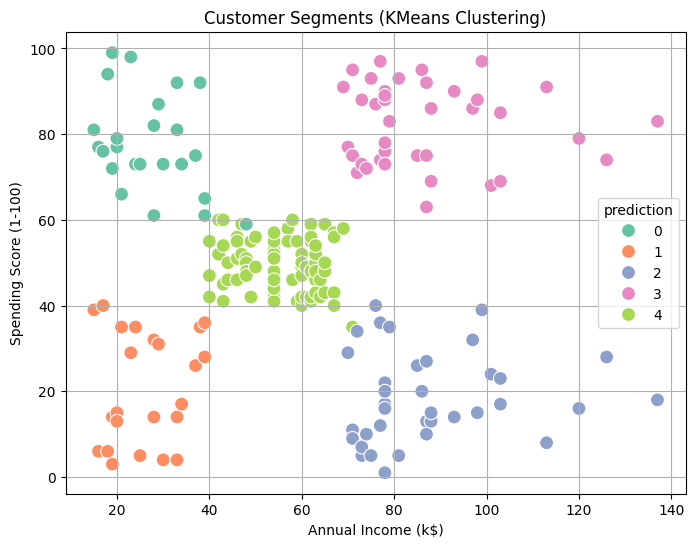

In [ ]:
# Step 1: Install Spark and findspark if not already done


from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

# Step 3: Load dataset (Mall_Customers.csv)
df = spark.read.csv("/content/Mall_Customers.csv", header=True, inferSchema=True)
df.show(5)

# Step 4: Select numerical features only
data = df.select("Age", "Annual Income (k$)", "Spending Score (1-100)")

# Step 5: VectorAssembler to create feature column
from pyspark.ml.feature import VectorAssembler
vec = VectorAssembler(inputCols=data.columns, outputCol="features")
final_data = vec.transform(data)

# Step 6: KMeans Clustering
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(final_data)

# Step 7: Make predictions
predictions = model.transform(final_data)

# Step 8: Show the first few rows to inspect the data
predictions.select("Age", "Annual Income (k$)", "Spending Score (1-100)", "prediction").show(5, truncate=False)

# Step 9: Convert to Pandas for plotting
pandas_df = predictions.select("Age", "Annual Income (k$)", "Spending Score (1-100)", "prediction").toPandas()

# Step 10: Visualization using Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=pandas_df, x="Annual Income (k$)", y="Spending Score (1-100)", hue="prediction", palette="Set2", s=100)
plt.title("Customer Segments (KMeans Clustering)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.show()


In [ ]:
##q3)
# Step 3: Load dataset (upload '1662574418893344.csv' to Colab)
df = spark.read.csv("/content/1662574418893344.csv", header=True, inferSchema=True)
df.show(5)

# Step 4: Check the schema of the dataset
df.printSchema()

# Step 5: Feature extraction using TF-IDF on 'Describe' column
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
tokenizer = Tokenizer(inputCol="Describe", outputCol="words")
words_data = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# Step 6: Show transformed features
rescaled_data.select("Food_ID", "Name", "features").show(5)

# Step 7: Build similarity model (e.g., cosine similarity) using the features
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Summarizer

# Step 8: Recommend similar items based on food description (Cosine Similarity)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# VectorAssembler to combine the features
assembler = VectorAssembler(inputCols=["features"], outputCol="feature_vector")
data_vector = assembler.transform(rescaled_data)

# Perform KMeans clustering to group similar food items based on description
kmeans = KMeans(k=5, seed=1, featuresCol="feature_vector", predictionCol="cluster")
model = kmeans.fit(data_vector)
predictions = model.transform(data_vector)

# Step 9: Show food items grouped by similar clusters
predictions.select("Food_ID", "Name", "cluster").show(5)

# Step 10: You can recommend food items within the same cluster
# For instance, to recommend items in the same cluster for a specific food item:
recommended_items = predictions.filter(predictions.cluster == 0)  # Cluster 0 as an example
recommended_items.select("Food_ID", "Name").show(5)

+-------+--------------------+------------+-------+--------------------+
|Food_ID|                Name|      C_Type|Veg_Non|            Describe|
+-------+--------------------+------------+-------+--------------------+
|      1| summer squash salad|Healthy Food|    veg|white balsamic vi...|
|      2|chicken minced salad|Healthy Food|non-veg|olive oil, chicke...|
|      3|sweet chilli almonds|       Snack|    veg|almonds whole, eg...|
|      4|     tricolour salad|Healthy Food|    veg|vinegar, honey/su...|
|      5|      christmas cake|     Dessert|    veg|christmas dry fru...|
+-------+--------------------+------------+-------+--------------------+
only showing top 5 rows

root
 |-- Food_ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- C_Type: string (nullable = true)
 |-- Veg_Non: string (nullable = true)
 |-- Describe: string (nullable = true)

+-------+--------------------+--------------------+
|Food_ID|                Name|            features|
+-------+------

In [4]:
!git clone https://github.com/GautamTopper/160122771039-BDA.git


Cloning into '160122771039-BDA'...


In [6]:
!mv /content/160122771039.ipynb /content/160122771039-BDA/


mv: cannot stat '/content/160122771039.ipynb': No such file or directory


In [7]:
%cd /content/160122771039-BDA


/content/160122771039-BDA


In [10]:
# Clone the repository
!git clone https://github.com/GautamTopper/160122771039-BDA.git

# Change directory to the cloned repository
%cd 160122771039-BDA

# Add your notebook file (replace 'your_notebook.ipynb' with the actual name of your notebook)
!git add your_notebook.ipynb

# Commit the changes
!git commit -m "Add initial Colab notebook"

# Push to GitHub (assuming your branch is 'main')
!git push -u origin main


Cloning into '160122771039-BDA'...
/content/160122771039-BDA/160122771039-BDA/160122771039-BDA
fatal: pathspec 'your_notebook.ipynb' did not match any files
On branch main

Initial commit

nothing to commit (create/copy files and use "git add" to track)
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/GautamTopper/160122771039-BDA.git'
